In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os.path as osp
shared_folder = osp.abspath(osp.join('..', '..', 'share'))
import sys
if shared_folder not in sys.path: sys.path.insert(1, shared_folder)
from notebook_utils import NotebookUtilities
nu = NotebookUtilities(
    data_folder_path=osp.abspath(osp.join('..', 'data')),
    saves_folder_path=osp.abspath(osp.join('..', 'saves'))
)

# Import needed libraries
import re
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
from matplotlib.patches import Rectangle
import wikipedia
bs = wikipedia.BeautifulSoup
import numpy as np

In [3]:

generations_df = nu.load_object('generations_df')
turning_numbers_df = nu.load_object('turning_numbers_df')
turnings_df = nu.load_object('turnings_df')


# Covers of Time Magazine

In [4]:

import ephem
from datetime import datetime, timedelta, date

def first_day_of_spring(year):
    observer = ephem.Observer()
    observer.lon, observer.lat = '0', '0'  # Observer at the Prime Meridian
    spring_equinox = ephem.next_equinox(datetime(year, 3, 20))  # Assuming March 20th for the equinox

    return spring_equinox.datetime()

# Example for 2022
year = 2022
spring_date_ephem = first_day_of_spring(year)
print(type(spring_date_ephem))

<class 'datetime.datetime'>


In [5]:

now = datetime.now()
if nu.pickle_exists('time_covers_df'): time_covers_df = nu.load_object('time_covers_df')
else:
    rows_list = []
    for i in range(1920, now.year, 10):
        page_obj = wikipedia.WikipediaPage(title=f'List of covers of Time magazine ({i}s)')
        page_html = page_obj.html()
        page_soup = bs(page_html, 'html.parser')
        # <div class="mw-content-ltr mw-parser-output" lang="en" dir="ltr"><p class="mw-empty-elt">
        content_soups_list = page_soup.find_all('div', attrs={'class': ['mw-content-ltr', 'mw-parser-output'], 'lang': 'en', 'dir': 'ltr'})
        for content_soup in content_soups_list:
            # <span class="mw-headline" id="1923">1923</span>
            h2_soups_list = content_soup.find_all('span', attrs={'class': 'mw-headline', 'id': re.compile(r'\d+')})
            for h2_soup in h2_soups_list:
                year = int(h2_soup.text.strip())
                if year < 1990:
                    # <div class="div-col" style="column-width: 22em;">
                    col_soup = h2_soup.parent.find_next('div', attrs={'class': 'div-col', 'style': 'column-width: 22em;'})
                    li_soups_list = col_soup.find_all('li')
                    for li_soup in li_soups_list:
                        issue_strs_list = re.split(' +[–-] +', li_soup.text.strip(), 0)
                        month, day = issue_strs_list[0].split()
                        try: date_obj = datetime.strptime(f'{month} {day}, {year}', '%B %d, %Y')
                        except ValueError: date_obj = datetime.strptime(f'{month} {day}, {year}', '%b %d, %Y')
                        # <a href="/wiki/Joseph_Gurney_Cannon" title="Joseph Gurney Cannon">Joseph G. Cannon</a>
                        a_soups_list = li_soup.find_all('a', attrs={'href': True, 'title': True})
                        for a_soup in a_soups_list:
                            cover_topic = a_soup['title']
                            row_dict = {'magazine_date': date_obj, 'cover_topic': cover_topic}
                            rows_list.append(row_dict)
                else:
                    # <table class="wikitable">
                    table_soup = h2_soup.parent.find_next('table', attrs={'class': 'wikitable'})
                    tr_soups_list = table_soup.find_all('tr')
                    for tr_soup in tr_soups_list:
                        th_soups_list = tr_soup.find_all('th')
                        td_soups_list = tr_soup.find_all('td')
                        if (len(th_soups_list) == 1) and (len(td_soups_list) == 2):
                            # <tr>
                                # <th>January 11</th>
                                # <td><a href="/wiki/Northwest_Airlines_Flight_253" title="Northwest Airlines Flight 253">Flight 253</a></td>
                                # <td>Fear of Flying/The 4 Lessons of Flight 253</td>
                            # </tr>
                            date_str = th_soups_list[0].text.strip()
                            a_soups_list = td_soups_list[0].find_all('a', attrs={'href': True, 'title': True})
                        elif (len(th_soups_list) == 0) and (len(td_soups_list) == 2):
                            # <tr>
                                # <td>January 1</td>
                                # <td>
                                    # <a href="/wiki/Mikhail_Gorbachev" title="Mikhail Gorbachev">Mikhail Gorbachev</a>, 
                                    # <a href="/wiki/Time_Person_of_the_Year" title="Time Person of the Year">Man of the Decade</a>
                                # </td>
                            # </tr>
                            date_str = td_soups_list[0].text.strip()
                            a_soups_list = td_soups_list[1].find_all('a', attrs={'href': True, 'title': True})
                        else: continue
                        if (date_str == 'Spring'): date_str = first_day_of_spring(year).strftime('%B %d')
                        month, day = date_str.split('/')[0].split()
                        try: date_obj = datetime.strptime(f'{month} {day}, {year}', '%B %d, %Y')
                        except ValueError: date_obj = datetime.strptime(f'{month} {day}, {year}', '%b %d, %Y')
                        for a_soup in a_soups_list:
                            topic_str = a_soup['title']
                            row_dict = {'magazine_date': date_obj, 'cover_topic': topic_str}
                            rows_list.append(row_dict)
    time_covers_df = pd.DataFrame(rows_list)
    nu.store_objects(time_covers_df=time_covers_df)

In [6]:

if nu.pickle_exists('time_cover_bios_df'): time_cover_bios_df = nu.load_object('time_cover_bios_df')
else:
    time_cover_bios_df = nu.get_wiki_infobox_data_frame(time_covers_df.cover_topic.unique())
    nu.store_objects(time_cover_bios_df=time_cover_bios_df, time_covers_df=time_covers_df)

In [7]:

mask_series = time_cover_bios_df.born.isnull()
time_cover_bios_df[mask_series].dropna(axis='columns', how='all').T

,4,7,41,62,63,73,108,131,156,177,...,3480,3483,3485,3486,3491,3499,3504,3505,3506,3507
page_title,Stephen Sanford (polo player),Samuel M. Vauclain,Anton Lang,Homer Saint-Gaudens,Henry Seidel Canby,William Sproule,George Harold Sisler,Zachary Lansdowne,Marion N. Talley,George E. Brennan,...,Flag of Ukraine,BTS,Shohei Ohtani,Twitter,Olga Rudenko,The Lord of the Rings: The Rings of Power,Bukayo Saka,2022 FIFA World Cup,ChatGPT,Giza pyramid complex
preceded_by,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
speaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
died,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
spouse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008_2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Arsenal,NaN,NaN,NaN
2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Arsenal,NaN,NaN,NaN
stable_release,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"January 10, 2024; 3 days ago (2024-01-10)[1]",NaN
platform,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cloud computing platforms,NaN


In [8]:

# Compute year of birth and death
if 'year_of_birth' not in time_cover_bios_df.columns:
    years_regex = re.compile(r'\d{4}')
    mask_series = ~time_cover_bios_df['born'].isnull()
    time_cover_bios_df.loc[mask_series, 'year_of_birth'] = time_cover_bios_df[mask_series].born.map(lambda x: int(years_regex.findall(str(x))[0]) if years_regex.findall(str(x)) else np.nan, na_action='ignore')
    mask_series = ~time_cover_bios_df['died'].isnull()
    time_cover_bios_df.loc[mask_series, 'year_of_death'] = time_cover_bios_df[mask_series].died.map(lambda x: int(years_regex.findall(str(x))[0]) if years_regex.findall(str(x)) else np.nan, na_action='ignore')
    nu.store_objects(time_cover_bios_df=time_cover_bios_df)
    nu.save_data_frames(time_cover_bios_df=time_cover_bios_df)

In [9]:

# Add generation name and turnings archetype
if 'turnings_archetype' not in time_covers_df.columns:
    mask_series = ~time_cover_bios_df.year_of_birth.isnull()
    birth_dict = time_cover_bios_df[mask_series].set_index('page_title').year_of_birth.map(lambda x: int(x)).to_dict()
    for row_index, row_series in time_covers_df.iterrows():
        cover_topic = row_series.cover_topic
        year_of_birth = birth_dict.get(cover_topic)
        if not pd.isnull(year_of_birth):
            mask_series = (generations_df.birth_year_begin <= year_of_birth) & (generations_df.birth_year_end >= year_of_birth)
            if mask_series.any():
                generation_name = generations_df[mask_series].index.tolist()[0]
                turnings_archetype = generations_df[mask_series].turnings_archetype.tolist()[0]
            else:
                generation_name = np.nan
                turnings_archetype = np.nan
            time_covers_df.loc[row_index, 'generation_name'] = generation_name
            time_covers_df.loc[row_index, 'turnings_archetype'] = turnings_archetype
    nu.store_objects(time_covers_df=time_covers_df)
    nu.save_data_frames(time_covers_df=time_covers_df)

In [10]:

if 'publication_year' not in time_covers_df.columns:
    time_covers_df['publication_year'] = time_covers_df.magazine_date.map(lambda x: x.year)
    time_covers_df.publication_year = pd.to_numeric(time_covers_df.publication_year)
    nu.store_objects(time_covers_df=time_covers_df)
    nu.save_data_frames(time_covers_df=time_covers_df)

In [11]:

# Add turning number, name, and type
if 'turning_number' not in time_covers_df.columns:
    for row_index, row_series in time_covers_df.iterrows():
        publication_year = row_series.publication_year
        mask_series = (turnings_df.turning_year_begin <= publication_year) & (turnings_df.turning_year_end >= publication_year)
        if mask_series.any():
            
            # Get turning name
            turning_name = turnings_df[mask_series].index.tolist()[0]
            
            # Get turning number
            turning_number = turnings_df[mask_series].turning_number.tolist()[0]
            
        else:
            turning_name = np.nan
            turning_number = np.nan
        
        # Get turning type
        mask_series = (turning_numbers_df.index == turning_number)
        if mask_series.any(): turning_type = turning_numbers_df[mask_series].turning_type.tolist()[0]
        else: turning_type = np.nan
        
        time_covers_df.loc[row_index, 'turning_name'] = turning_name
        time_covers_df.loc[row_index, 'turning_number'] = turning_number
        time_covers_df.loc[row_index, 'turning_type'] = turning_type
    time_covers_df.turning_number = time_covers_df.turning_number.map(lambda x: int(x), na_action='ignore')
    time_covers_df.turning_number = pd.to_numeric(time_covers_df.turning_number)
    nu.store_objects(time_covers_df=time_covers_df)
    nu.save_data_frames(time_covers_df=time_covers_df)

In [54]:

# BenevolentCheese: Pretty cool trends. Can you give some examples of "nomads" that were on the cover?
mask_series = (time_covers_df.turnings_archetype == 'Nomad')
nu.conjunctify_nouns(time_covers_df[mask_series].sort_values('magazine_date', ascending=False).cover_topic.iloc[:5])

'Sultan Al Jaber, Deion Sanders, Elon Musk, John Fetterman, and Kim Kardashian'

In [13]:


# The group order (left to right)
turning_order = ['High', 'Awakening', 'Unraveling', 'Crisis']

# The order within the group
archetype_order = ['Hero', 'Artist', 'Prophet', 'Nomad']

# Sort DataFrame based on order
time_covers_df.turning_type = pd.Categorical(time_covers_df.turning_type, categories=turning_order, ordered=True)
time_covers_df.turnings_archetype = pd.Categorical(time_covers_df.turnings_archetype, categories=archetype_order, ordered=True)
time_covers_df = time_covers_df.sort_values(['turning_type', 'turnings_archetype'])
nu.store_objects(time_covers_df=time_covers_df)
nu.save_data_frames(time_covers_df=time_covers_df)

Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\Strauss-Howe\saves\pkl\time_covers_df.pkl
Saving to C:\Users\daveb\OneDrive\Documents\GitHub\Strauss-Howe\saves\csv\time_covers_df.csv


In [16]:

# Get the info dataset
if nu.pickle_exists('strauss_howe_info_df'): info_df = nu.load_object('strauss_howe_info_df')
else:
    df1 = turnings_df.reset_index()
    df2 = turning_numbers_df.reset_index().rename(columns={'index': 'turning_number'})
    on_list = list(set(df1.columns).intersection(set(df2.columns)))
    df3 = df1.merge(df2, on=on_list)
    df4 = generations_df.reset_index()
    on_list = list(set(df3.columns).intersection(set(df4.columns)))
    info_df = df3.merge(df4, on=on_list)
    nu.store_objects(strauss_howe_info_df=info_df)
    nu.save_data_frames(strauss_howe_info_df=info_df)

In [18]:

def add_turning_names_as_background_shading(ax, info_df, groupby_column_name, face_color_dict, verbose=False):
    
    # Add 5 units to the height
    if verbose: display(ax.get_ylim())
    bottom, top = ax.get_ylim()
    height_tuple = (bottom, top+5)
    ax.set_ylim(height_tuple)
    bottom, top = ax.get_ylim()
    height = top - bottom
    
    # Get the background shading wrap width
    if verbose: display(ax.get_xlim())
    xlim_left, xlim_right = ax.get_xlim()
    min_shading_width = 9999
    min_turning_name = ''
    wrap_width = info_df.turning_name.map(lambda x: len(x)).min()
    for row_index, row_series in info_df.iterrows():
        turning_year_begin = max(row_series.turning_year_begin, xlim_left)
        turning_year_end = min(row_series.turning_year_end, xlim_right)
        width = turning_year_end - turning_year_begin
        if (width > 0) and (width < min_shading_width):
            min_shading_width = width
            min_turning_name = row_series.turning_name
            wrap_width = len(min_turning_name)
    
    # Add the turning names as background shading
    for row_index, row_series in info_df.iterrows():
        turning_year_begin = max(row_series.turning_year_begin, xlim_left)
        turning_year_end = min(row_series.turning_year_end, xlim_right)
        width = turning_year_end - turning_year_begin
        if verbose: print(width)
        if (width > 0):
            groupby_column = row_series[groupby_column_name]
            turning_name = row_series.turning_name
            rect = Rectangle(
                (turning_year_begin, bottom), width, height, color=face_color_dict[groupby_column],
                fill=True, edgecolor=None, alpha=0.1
            )
            ax.add_patch(rect)
            plt.annotate(
                textwrap.fill(turning_name, width=wrap_width, break_long_words=False),
                (turning_year_begin+(width/2), top), textcoords='offset points', xytext=(0, -6),
                ha='center', fontsize=7, va='top', rotation=-90
            )


----


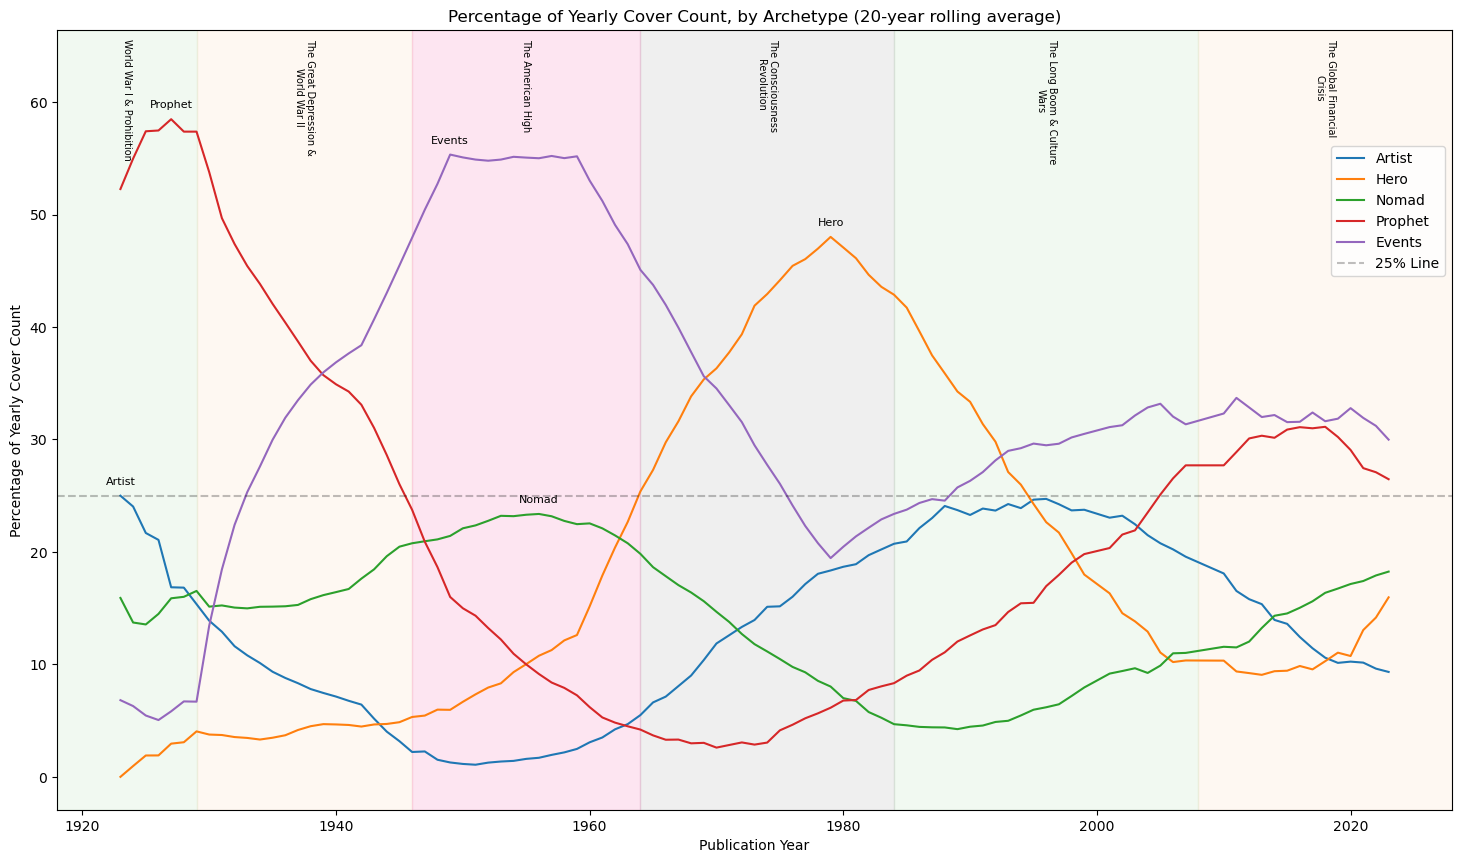

In [51]:

groupby_column_name = 'turnings_archetype'
year_totals_dict = time_covers_df.groupby(['publication_year'], dropna=True).count().magazine_date.to_dict()
df = time_covers_df.groupby(['publication_year', groupby_column_name], dropna=False).count().magazine_date.reset_index().rename(columns={'magazine_date': 'year_count'})
# df[groupby_column_name] = pd.Categorical(df[groupby_column_name], categories=archetype_order + ['Events'], ordered=True)
df[groupby_column_name] = df[groupby_column_name].astype(str)
# mask_series = (df[groupby_column_name] == 'nan')
# df.loc[mask_series, groupby_column_name] = 'Events'
def f(row_series):
    publication_year = row_series.publication_year
    year_count = row_series.year_count
    year_total = year_totals_dict[publication_year]
    year_percentage = 100 * year_count / year_total
    
    return year_percentage
df['year_percentage'] = df.apply(f, axis='columns')

# Convert 'publication_year' to numeric
df['publication_year'] = pd.to_numeric(df['publication_year'])

# Create the figure and axes
fig_width = 18
fig_height = fig_width/nu.twitter_aspect_ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Configure the color dictionary
color_cycler = nu.get_color_cycler(info_df[groupby_column_name].unique().shape[0])
face_color_dict = {}
for groupby_column, fc_dict in zip(
    info_df[groupby_column_name].unique(), color_cycler()
): face_color_dict[groupby_column] = fc_dict['color']

# Iterate over turnings_archetype groups
# display(df.groupby(groupby_column_name).groups.keys())
for turnings_archetype, turnings_archetype_df in df.groupby(groupby_column_name):
    
    # Calculate rolling mean
    turnings_archetype_df['mean_rolling_year_percentage'] = turnings_archetype_df.year_percentage.rolling(window=20, min_periods=1).mean()
    
    # Plot the line
    if (turnings_archetype == 'nan'):
        turnings_archetype_df.plot('publication_year', 'mean_rolling_year_percentage', label='Events', ax=ax)
    elif (turnings_archetype == 'Events'): continue
    else:
        turnings_archetype_df.plot('publication_year', 'mean_rolling_year_percentage', label=turnings_archetype, ax=ax)
    
    # Add text annotation at the max value point
    max_value = turnings_archetype_df['mean_rolling_year_percentage'].max()
    max_year = turnings_archetype_df.loc[turnings_archetype_df['mean_rolling_year_percentage'].idxmax(), 'publication_year']
    if (turnings_archetype == 'nan'):
        ax.annotate('Events', xy=(max_year, max_value), xytext=(max_year, max_value + 1), fontsize=8, ha='center')
    elif (turnings_archetype == 'Events'): continue
    else:
        ax.annotate(turnings_archetype, xy=(max_year, max_value), xytext=(max_year, max_value + 1), fontsize=8, ha='center')

# Add dashed horizontal line at 25%
ax.axhline(y=25, color='black', linestyle='--', label='25% Line', alpha=0.25)

# Set plot labels and title
ax.set_xlabel('Publication Year')
ax.set_ylabel('Percentage of Yearly Cover Count')
ax.set_title('Percentage of Yearly Cover Count, by Archetype (20-year rolling average)')

# JakeSteam: "The global financial crisis" is overlapped by the legend :(
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 0.86))


add_turning_names_as_background_shading(ax, info_df, groupby_column_name, face_color_dict, verbose=False)

In [17]:

import matplotlib.pyplot as plt

index_column = 'magazine_date'
groupby_columns = ['turnings_archetype', 'turning_type']
columns_list = [index_column] + groupby_columns
mask_series = True
for cn in columns_list: mask_series &= ~time_covers_df[cn].isnull()
df = time_covers_df[mask_series][columns_list].groupby(groupby_columns).count().reset_index().rename(columns={index_column: 'cover_count'})

# Sort DataFrame based on order
df['turning_type'] = pd.Categorical(df['turning_type'], categories=turning_order, ordered=True)
df['turnings_archetype'] = pd.Categorical(df['turnings_archetype'], categories=archetype_order, ordered=True)
df = df.sort_values(['turning_type', 'cover_count'], ascending=[True, False])

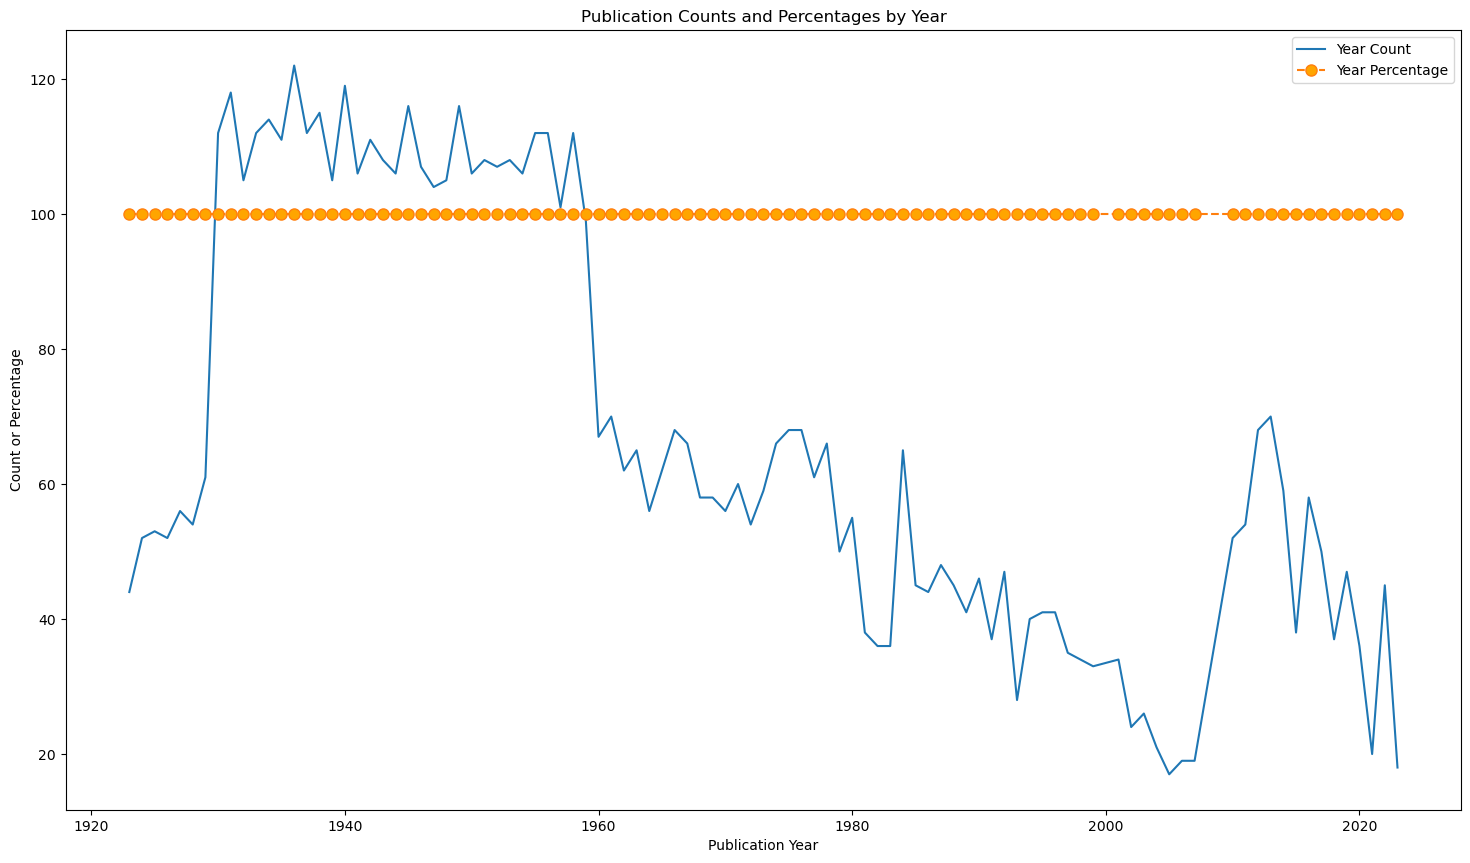

In [26]:

# Example data
publication_years = []
year_counts = []
year_percentages = []
for publication_year, publication_year_df in df.groupby('publication_year'):
    publication_years.append(publication_year)
    year_counts.append(publication_year_df.year_count.sum())
    year_percentages.append(publication_year_df.year_percentage.sum())

# Create the plot
fig_width = 18
fig_height = fig_width/nu.twitter_aspect_ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Plot year counts
ax.plot(publication_years, year_counts, label='Year Count')

# Plot year percentages (shifted to the right for clarity)
ax.plot(publication_years, year_percentages, label='Year Percentage', linestyle='--', marker='o', markersize=8, markerfacecolor='orange')

# Set labels and title
ax.set_xlabel('Publication Year')
ax.set_ylabel('Count or Percentage')
ax.set_title('Publication Counts and Percentages by Year')

# Add legend
ax.legend();

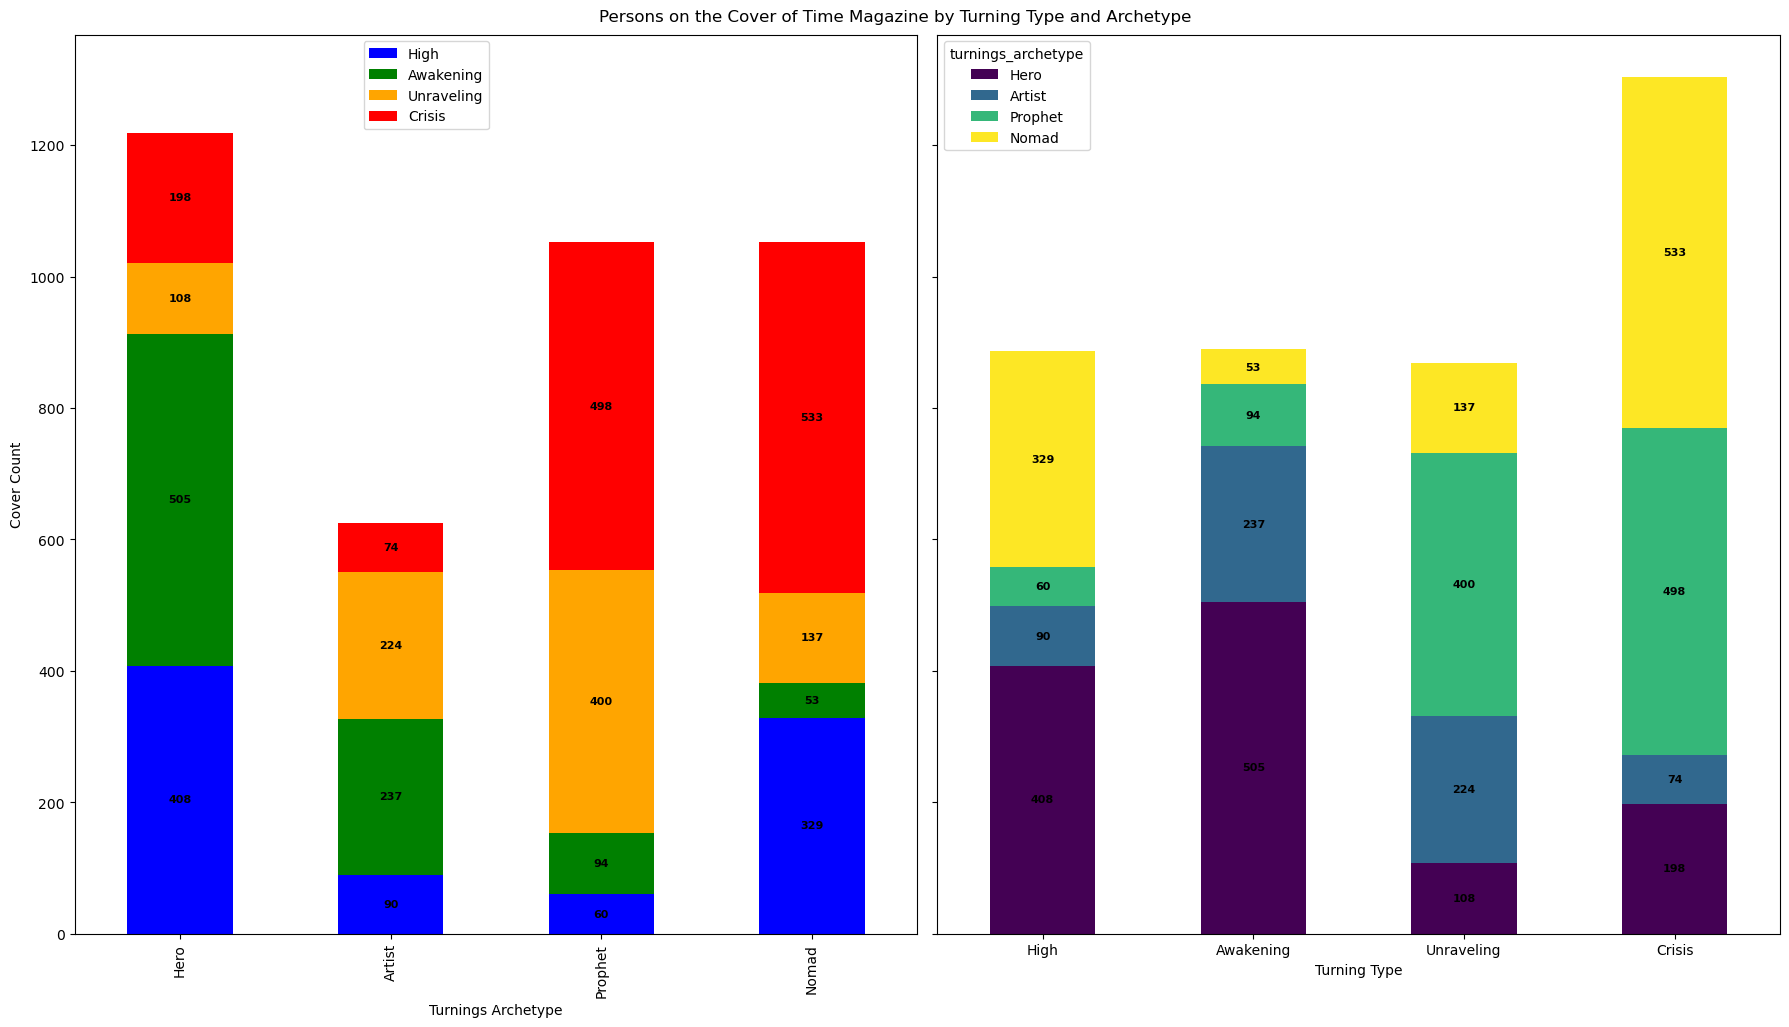

In [18]:

# Create the figure and axes
fig, (left_ax, right_ax) = plt.subplots(ncols=2, sharey=True, figsize=(fig_width, fig_height))

# Pivot the DataFrame for the first stacked bar plot
left_pivot_df = df.pivot(index='turnings_archetype', columns='turning_type', values='cover_count')

# Define custom colors for each turning type
colors = {'High': 'blue', 'Awakening': 'green', 'Unraveling': 'orange', 'Crisis': 'red'}

# Create the first stacked vertical bar plot with custom colors
left_pivot_df.plot(kind='bar', stacked=True, color=[colors[col] for col in left_pivot_df.columns], ax=left_ax)

# Move the legend above the "Artist" column
artist_index = left_pivot_df.index.tolist().index('Artist') + 1
left_ax.legend(loc='upper right', bbox_to_anchor=(artist_index / left_pivot_df.shape[0], 1.0))

# Set plot labels and title for the first plot
left_ax.set_xlabel('Turnings Archetype')
left_ax.set_ylabel('Cover Count')

# Pivot the DataFrame for the second stacked bar plot
right_pivot_df = df.pivot(index='turning_type', columns='turnings_archetype', values='cover_count')

# Create the second stacked vertical bar plot
right_pivot_df.plot(kind='bar', stacked=True, colormap='viridis', rot=0, ax=right_ax)

# Set plot labels and title for the second plot
right_ax.set_xlabel('Turning Type')
right_ax.set_ylabel('Cover Count')

# Add black text annotations in the middle of each rectangle for both plots
for ax in [left_ax, right_ax]:
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', color='black', fontsize=8, weight='bold', label_type='center')

# Adjust layout and display the plot
plt.tight_layout()
plt.suptitle('Persons on the Cover of Time Magazine by Turning Type and Archetype', y=1.01)

# Display the plot
plt.show()

In [20]:

from matplotlib.patches import Rectangle

# Configure the color dictionary
groupby_column_name = 'turning_type'
color_cycler = nu.get_color_cycler(info_df[groupby_column_name].unique().shape[0])
face_color_dict = {}
for groupby_column, fc_dict in zip(
    info_df[groupby_column_name].unique(), color_cycler()
): face_color_dict[groupby_column] = fc_dict['color']

In [21]:

nu.get_column_descriptions(time_covers_df)

,column_name,dtype,count_blanks,count_uniques,count_zeroes,has_dates,min_value,max_value,only_integers
0,turnings_archetype,category,2606,5,0,False,Hero,Nomad,NaN
1,turning_type,category,0,4,0,False,High,Crisis,NaN
2,magazine_date,datetime64[ns],0,4020,0,True,1923-03-03 00:00:00,2023-12-06 00:00:00,NaN
3,publication_year,int64,0,98,0,True,1923,2023,True
4,turning_number,int64,0,4,0,True,1,4,True
5,cover_topic,object,0,3609,0,False,14th Dalai Lama,Şükrü Saracoğlu,NaN
6,generation_name,object,2606,19,0,False,13th,Transcendental,NaN
7,turning_name,object,0,6,0,False,The American High,World War I & Prohibition,NaN


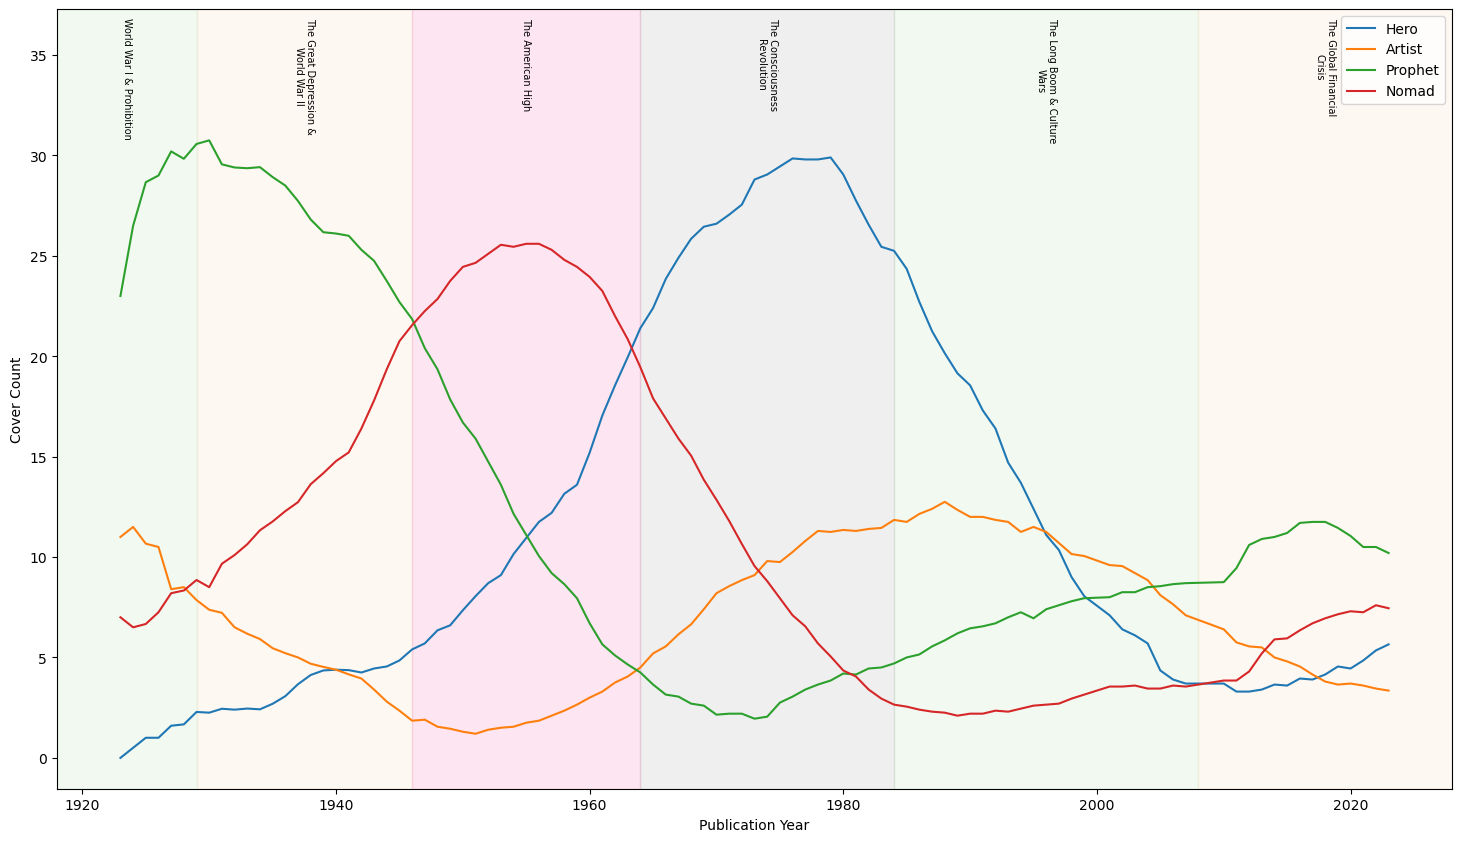

In [22]:

index_column = 'magazine_date'
groupby_columns = ['publication_year', 'turnings_archetype']
columns_list = [index_column] + groupby_columns
mask_series = True
for cn in columns_list: mask_series &= ~time_covers_df[cn].isnull()
df = time_covers_df[mask_series][columns_list].groupby(groupby_columns).count().reset_index().rename(columns={index_column: 'cover_count'})

# Sort DataFrame based on order
df['turnings_archetype'] = pd.Categorical(df['turnings_archetype'], categories=archetype_order, ordered=True)
df = df.sort_values(groupby_columns, ascending=[True, True])

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
for turnings_archetype, turnings_archetype_df in df.groupby('turnings_archetype'):
    turnings_archetype_df['mean_rolling_cover_count'] = turnings_archetype_df.cover_count.rolling(window=20, min_periods=1).mean()
    turnings_archetype_df.plot('publication_year', 'mean_rolling_cover_count', label=turnings_archetype, ax=ax)
ax.set_xlabel('Publication Year')
ax.set_ylabel('Cover Count')
add_turning_names_as_background_shading(ax, info_df, groupby_column_name, face_color_dict, verbose=False)

In [167]:

nu.open_path_in_notepad(r'C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py')

Attempting to open C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py
